In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
image_folder = "./../data/training-a"
folder_info_csv = "./../data/training-a.csv"

In [3]:
df_info = pd.read_csv(folder_info_csv)
df_info.head()

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


# Image processing and flattend arrays

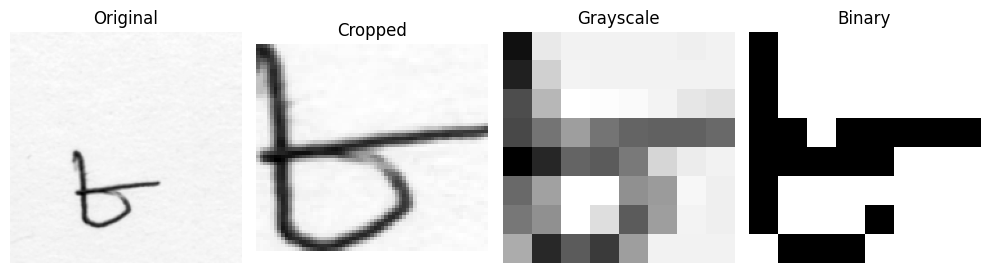

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# --------- Pick a random image from dataframe ---------
# df_info should contain columns 'filename' and 'digit'
random_row = df_info.sample(n=1).iloc[0]  # randomly select one row
img_name = random_row['filename']         # get image filename
label = random_row['digit']               # get corresponding label

# Build full path to the image
img_path = os.path.join(image_folder, img_name)

# --------- Load original image ---------
img_original = Image.open(img_path).convert('L')  # convert to grayscale
img_array = np.array(img_original)               # convert to numpy array for processing

# --------- Crop whitespace using threshold ---------
# Define threshold for what counts as "background"
threshold = 128  # pixel values >= threshold are considered background

# Create a boolean mask where pixels < threshold are foreground
mask = img_array < threshold

if mask.any():
    # Find coordinates of foreground pixels
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)   # top-left corner
    y1, x1 = coords.max(axis=0)+1 # bottom-right corner (+1 because slice end is exclusive)
    # Crop image to bounding box
    img_cropped = img_original.crop((x0, y0, x1, y1))
else:
    # If no foreground detected, just copy original
    img_cropped = img_original.copy()

# --------- Resize cropped image ---------
# Resize image to 8x8 pixels (e.g., for ML feature input)
img_resized = img_cropped.resize((8,8))

# --------- Convert to array ---------
img_array_resized = np.array(img_resized, dtype=np.float32)

# --------- Normalize grayscale to [0,1] ---------
img_gray = (img_array_resized - img_array_resized.min()) / (img_array_resized.max() - img_array_resized.min())

# --------- Convert to binary image using threshold ---------
img_binary = (img_gray >= 0.5).astype(np.float32)  # pixels >=0.5 become 1, else 0

# --------- Visualize all stages ---------
plt.figure(figsize=(10,5))

plt.subplot(1,4,1)
plt.imshow(img_original, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(img_cropped, cmap="gray")
plt.title("Cropped")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(img_gray, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(img_binary, cmap="gray")
plt.title("Binary")
plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch

# ---------------- Paths ----------------
image_folder = "./../data/training-a"
output_folder = "./../features/training-a/flattened_arrays"
csv_file = "./../data/training-a.csv"  # replace with your CSV path

os.makedirs(output_folder, exist_ok=True)

# ---------------- Load labels CSV ----------------
df = pd.read_csv(csv_file)
filename_to_label = dict(zip(df['filename'], df['digit']))

# ---------------- Helper Function ----------------
def flatten_image(img_path, binary=False, resize_to=(8,8), threshold_crop=128):
    """
    Loads an image, crops whitespace, resizes, normalizes,
    converts to binary (optional), and flattens to a 1D array.
    """
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)

    # Crop whitespace/background
    mask = img_array < threshold_crop  # non-background pixels
    if mask.any():
        coords = np.argwhere(mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        img = img.crop((x0, y0, x1, y1))

    # Resize
    img = img.resize(resize_to)

    # Normalize
    img_array = np.array(img, dtype=np.float32)
    img_norm = (img_array - img_array.min()) / (img_array.max() - img_array.min())

    # Convert to binary if requested
    if binary:
        img_norm = (img_norm >= 0.5).astype(np.float32)

    return img_norm.flatten()

# ---------------- Process Images ----------------
files = sorted(os.listdir(image_folder))
X_gray, y_gray = [], []
X_binary, y_binary = [], []

for f in tqdm(files, desc="Processing images"):
    if f not in filename_to_label:
        continue  # skip any file not in CSV
    label = int(filename_to_label[f])
    path = os.path.join(image_folder, f)

    # Grayscale
    X_gray.append(flatten_image(path, binary=False))
    y_gray.append(label)

    # Binary
    X_binary.append(flatten_image(path, binary=True))
    y_binary.append(label)

# Convert to numpy arrays
X_gray = np.array(X_gray, dtype=np.float32)
y_gray = np.array(y_gray, dtype=np.int64)
X_binary = np.array(X_binary, dtype=np.float32)
y_binary = np.array(y_binary, dtype=np.int64)

# Save arrays
np.save(os.path.join(output_folder, "X_gray_8.npy"), X_gray)
np.save(os.path.join(output_folder, "y_gray_8.npy"), y_gray)
np.save(os.path.join(output_folder, "X_binary_8.npy"), X_binary)
np.save(os.path.join(output_folder, "y_binary_8.npy"), y_binary)

print("✅ Flattening and cropping complete!")
print(f"Grayscale shape: {X_gray.shape}, Binary shape: {X_binary.shape}")

Processing images: 100%|█████████████████████████████████████████████████████████| 19702/19702 [04:47<00:00, 68.58it/s]


✅ Flattening and cropping complete!
Grayscale shape: (19702, 64), Binary shape: (19702, 64)


# tsne features

Grayscale shape: (19702, 64)
Binary shape: (19702, 64)


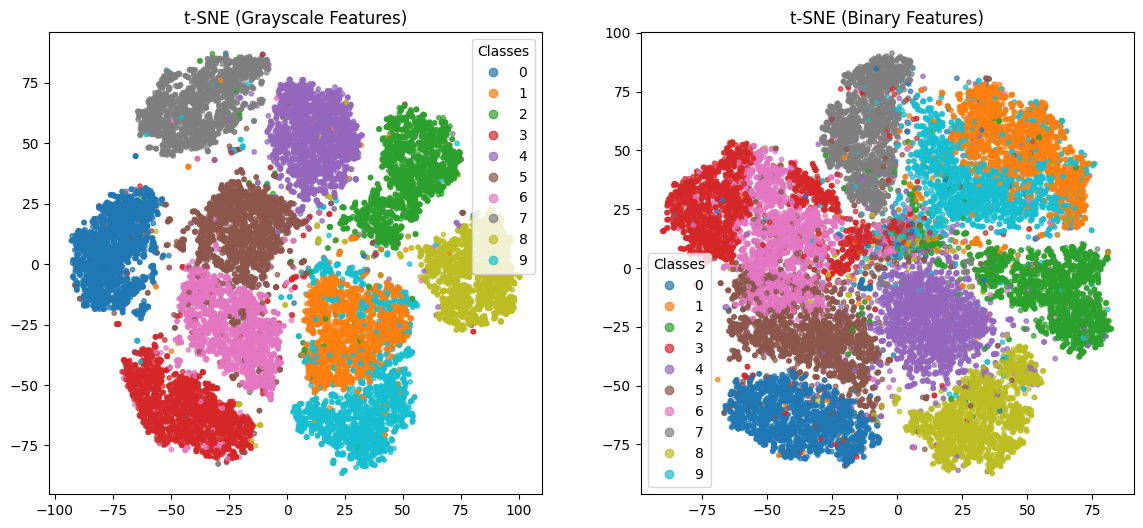

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load features
features_folder = "./../features/training-a/flattened_arrays"

X_gray = np.load(f"{features_folder}/X_gray.npy")
y_gray = np.load(f"{features_folder}/y_gray.npy")

X_binary = np.load(f"{features_folder}/X_binary.npy")
y_binary = np.load(f"{features_folder}/y_binary.npy")

print("Grayscale shape:", X_gray.shape)
print("Binary shape:", X_binary.shape)

from sklearn.manifold import TSNE

# --- Run t-SNE on grayscale features ---
tsne_gray = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_gray_2d = tsne_gray.fit_transform(X_gray)

# --- Run t-SNE on binary features ---
tsne_binary = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_binary_2d = tsne_binary.fit_transform(X_binary)

# --- Plot results ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Grayscale plot
scatter1 = axs[0].scatter(X_gray_2d[:, 0], X_gray_2d[:, 1], c=y_gray, cmap="tab10", s=10, alpha=0.7)
axs[0].set_title("t-SNE (Grayscale Features)")
axs[0].legend(*scatter1.legend_elements(), title="Classes")

# Binary plot
scatter2 = axs[1].scatter(X_binary_2d[:, 0], X_binary_2d[:, 1], c=y_binary, cmap="tab10", s=10, alpha=0.7)
axs[1].set_title("t-SNE (Binary Features)")
axs[1].legend(*scatter2.legend_elements(), title="Classes")

plt.show()


# umap features

In [10]:
import umap
import numpy as np

# ==========================================
# 1. Processing Grayscale Data
# ==========================================
print("Processing Grayscale Data...")

# --- UMAP (4 Features) ---
print("  - Reducing to 4 dimensions...")
umap_gray_4 = umap.UMAP(n_components=4, random_state=42)
X_gray_umap_4 = umap_gray_4.fit_transform(X_gray)
np.save("X_gray_umap_4.npy", X_gray_umap_4)

# --- UMAP (8 Features) ---
print("  - Reducing to 8 dimensions...")
umap_gray_8 = umap.UMAP(n_components=8, random_state=42)
X_gray_umap_8 = umap_gray_8.fit_transform(X_gray)
np.save("X_gray_umap_8.npy", X_gray_umap_8)

# --- Save Labels (Once) ---
# Labels don't change between 4 and 8 features
np.save("y_gray.npy", y_gray) 

# Optional check
print(f"  > Saved Gray 4-dim shape: {X_gray_umap_4.shape}")
print(f"  > Saved Gray 8-dim shape: {X_gray_umap_8.shape}")


# ==========================================
# 2. Processing Binary Data
# ==========================================
print("\nProcessing Binary Data...")

# --- UMAP (4 Features) ---
print("  - Reducing to 4 dimensions...")
umap_binary_4 = umap.UMAP(n_components=4, random_state=42)
X_binary_umap_4 = umap_binary_4.fit_transform(X_binary)
np.save("X_binary_umap_4.npy", X_binary_umap_4)

# --- UMAP (8 Features) ---
print("  - Reducing to 8 dimensions...")
umap_binary_8 = umap.UMAP(n_components=8, random_state=42)
X_binary_umap_8 = umap_binary_8.fit_transform(X_binary)
np.save("X_binary_umap_8.npy", X_binary_umap_8)

# --- Save Labels (Once) ---
np.save("y_binary.npy", y_binary)

# Optional check
print(f"  > Saved Binary 4-dim shape: {X_binary_umap_4.shape}")
print(f"  > Saved Binary 8-dim shape: {X_binary_umap_8.shape}")

Processing Grayscale Data...
  - Reducing to 4 dimensions...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  - Reducing to 8 dimensions...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  > Saved Gray 4-dim shape: (19702, 4)
  > Saved Gray 8-dim shape: (19702, 8)

Processing Binary Data...
  - Reducing to 4 dimensions...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  - Reducing to 8 dimensions...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  > Saved Binary 4-dim shape: (19702, 4)
  > Saved Binary 8-dim shape: (19702, 8)


Running t-SNE and plotting...
  > Processing: Grayscale (4 UMAP Features)...
  > Processing: Grayscale (8 UMAP Features)...
  > Processing: Binary (4 UMAP Features)...
  > Processing: Binary (8 UMAP Features)...


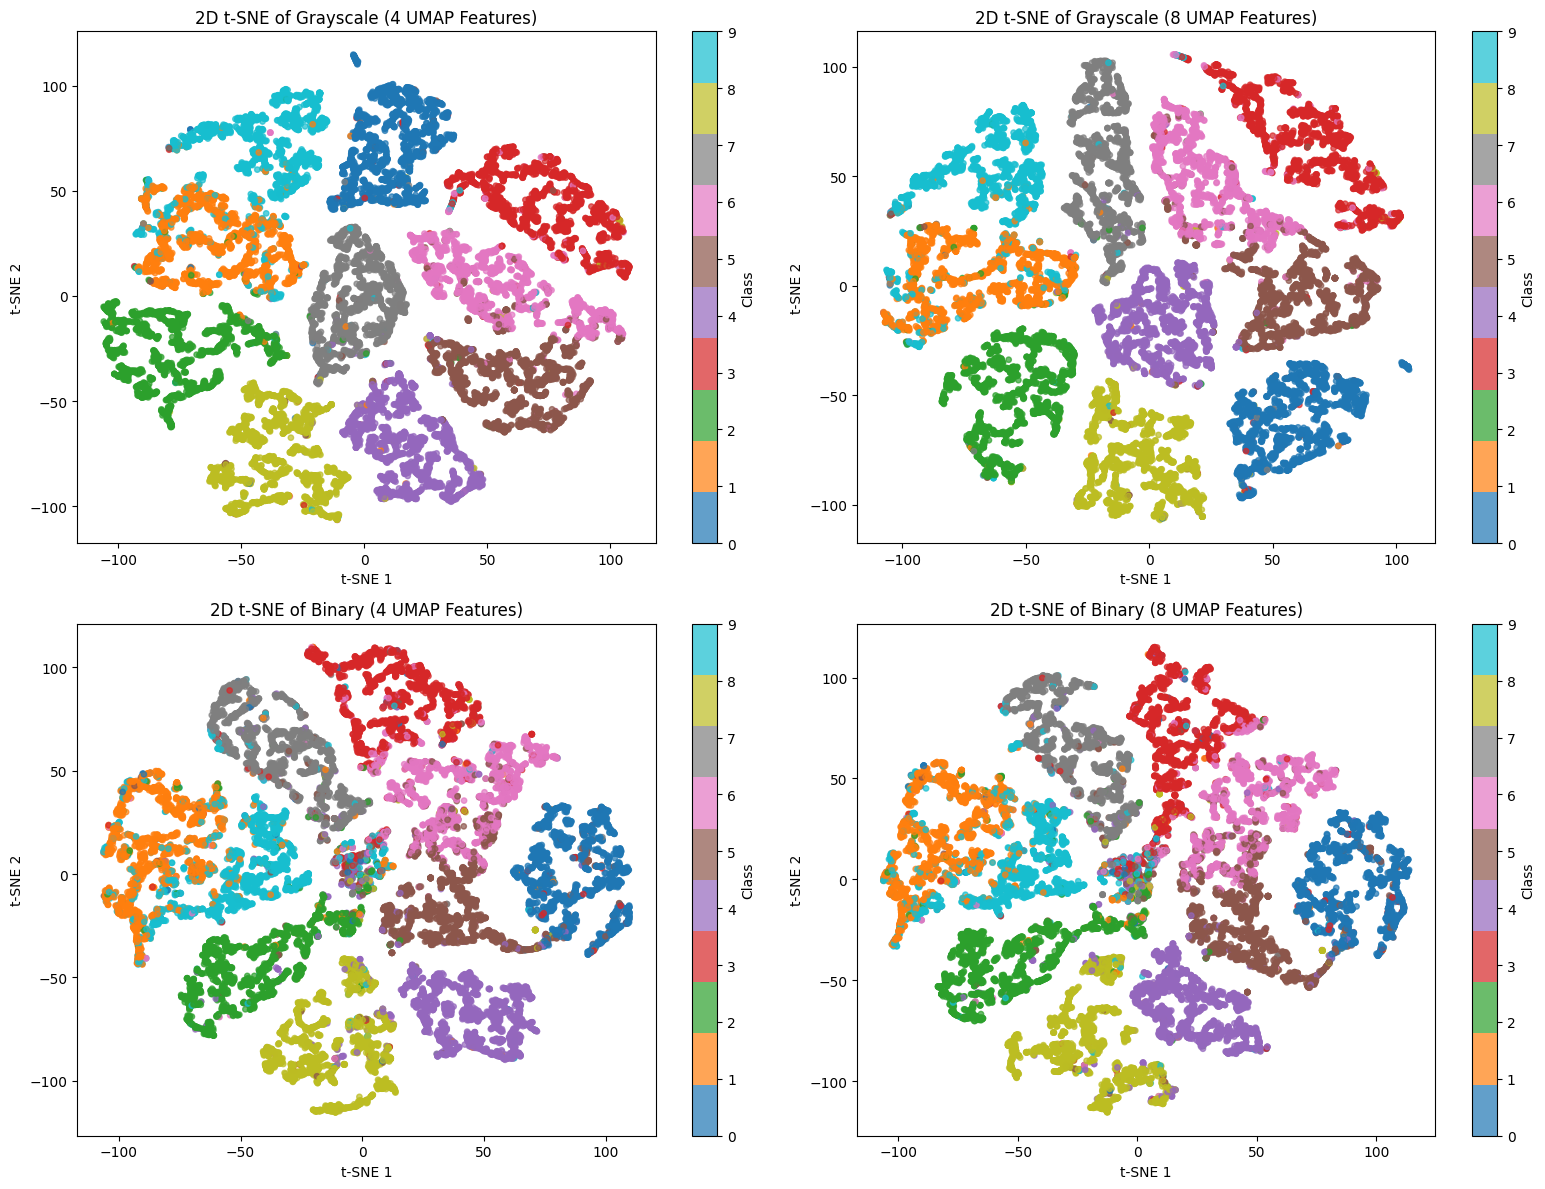

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# List of datasets to process
# Format: (features, labels, title)
datasets = [
    (X_gray_umap_4,   y_gray,   "Grayscale (4 UMAP Features)"),
    (X_gray_umap_8,   y_gray,   "Grayscale (8 UMAP Features)"),
    (X_binary_umap_4, y_binary, "Binary (4 UMAP Features)"),
    (X_binary_umap_8, y_binary, "Binary (8 UMAP Features)")
]

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel() # Flatten 2D array of axes to 1D for easy looping

print("Running t-SNE and plotting...")

for i, (features, labels, title) in enumerate(datasets):
    print(f"  > Processing: {title}...")
    
    # --- t-SNE reduction ---
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    X_tsne = tsne.fit_transform(features)
    
    # --- Plotting ---
    scatter = axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=15, alpha=0.7)
    
    axes[i].set_title(f"2D t-SNE of {title}")
    axes[i].set_xlabel("t-SNE 1")
    axes[i].set_ylabel("t-SNE 2")
    
    # Add a colorbar for each plot (optional, or add one shared legend)
    plt.colorbar(scatter, ax=axes[i], label='Class')

plt.tight_layout()
plt.show()

In [2]:
import umap
import numpy as np
from sklearn.model_selection import train_test_split

# Config for split
TEST_SIZE = 0.2
RANDOM_STATE = 42

# ==========================================
# 1. Processing Grayscale Data
# ==========================================
print("Processing Grayscale Data...")

# --- Split Train/Test ---
print("   - Splitting Grayscale data into Train/Test...")
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(
    X_gray, y_gray, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Save Labels (Now split)
np.save("y_train_gray.npy", y_train_gray)
np.save("y_test_gray.npy", y_test_gray)

# --- UMAP (4 Features) ---
print("   - Reducing to 4 dimensions (Supervised)...")
umap_gray_4 = umap.UMAP(n_components=4, random_state=42)

# Fit on Train (WITH LABELS for Supervised), Transform Test
# CHANGED: Passed y_train_gray here
X_train_gray_umap_4 = umap_gray_4.fit_transform(X_train_gray, y_train_gray)
X_test_gray_umap_4 = umap_gray_4.transform(X_test_gray)

np.save("X_train_gray_umap_4.npy", X_train_gray_umap_4)
np.save("X_test_gray_umap_4.npy", X_test_gray_umap_4)

# --- UMAP (8 Features) ---
print("   - Reducing to 8 dimensions (Supervised)...")
umap_gray_8 = umap.UMAP(n_components=8, random_state=42)

# Fit on Train (WITH LABELS for Supervised), Transform Test
# CHANGED: Passed y_train_gray here
X_train_gray_umap_8 = umap_gray_8.fit_transform(X_train_gray, y_train_gray)
X_test_gray_umap_8 = umap_gray_8.transform(X_test_gray)

np.save("X_train_gray_umap_8.npy", X_train_gray_umap_8)
np.save("X_test_gray_umap_8.npy", X_test_gray_umap_8)

# Optional check
print(f"   > Saved Gray Train 4-dim shape: {X_train_gray_umap_4.shape}")
print(f"   > Saved Gray Test 4-dim shape:  {X_test_gray_umap_4.shape}")


# ==========================================
# 2. Processing Binary Data
# ==========================================
print("\nProcessing Binary Data...")

# --- Split Train/Test ---
print("   - Splitting Binary data into Train/Test...")
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary, y_binary, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Save Labels
np.save("y_train_binary.npy", y_train_binary)
np.save("y_test_binary.npy", y_test_binary)

# --- UMAP (4 Features) ---
print("   - Reducing to 4 dimensions (Supervised)...")
umap_binary_4 = umap.UMAP(n_components=4, random_state=42)

# Fit on Train (WITH LABELS for Supervised), Transform Test
# CHANGED: Passed y_train_binary here
X_train_binary_umap_4 = umap_binary_4.fit_transform(X_train_binary, y_train_binary)
X_test_binary_umap_4 = umap_binary_4.transform(X_test_binary)

np.save("X_train_binary_umap_4.npy", X_train_binary_umap_4)
np.save("X_test_binary_umap_4.npy", X_test_binary_umap_4)

# --- UMAP (8 Features) ---
print("   - Reducing to 8 dimensions (Supervised)...")
umap_binary_8 = umap.UMAP(n_components=8, random_state=42)

# Fit on Train (WITH LABELS for Supervised), Transform Test
# CHANGED: Passed y_train_binary here
X_train_binary_umap_8 = umap_binary_8.fit_transform(X_train_binary, y_train_binary)
X_test_binary_umap_8 = umap_binary_8.transform(X_test_binary)

np.save("X_train_binary_umap_8.npy", X_train_binary_umap_8)
np.save("X_test_binary_umap_8.npy", X_test_binary_umap_8)

# Optional check
print(f"   > Saved Binary Train 4-dim shape: {X_train_binary_umap_4.shape}")
print(f"   > Saved Binary Test 4-dim shape:  {X_test_binary_umap_4.shape}")

Processing Grayscale Data...
   - Splitting Grayscale data into Train/Test...
   - Reducing to 4 dimensions (Supervised)...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   - Reducing to 8 dimensions (Supervised)...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   > Saved Gray Train 4-dim shape: (15761, 4)
   > Saved Gray Test 4-dim shape:  (3941, 4)

Processing Binary Data...
   - Splitting Binary data into Train/Test...
   - Reducing to 4 dimensions (Supervised)...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   - Reducing to 8 dimensions (Supervised)...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   > Saved Binary Train 4-dim shape: (15761, 4)
   > Saved Binary Test 4-dim shape:  (3941, 4)


Running t-SNE on Test Sets and plotting...
  > Processing: Grayscale Test (4 UMAP Features)...
  > Processing: Grayscale Test (8 UMAP Features)...
  > Processing: Binary Test (4 UMAP Features)...
  > Processing: Binary Test (8 UMAP Features)...


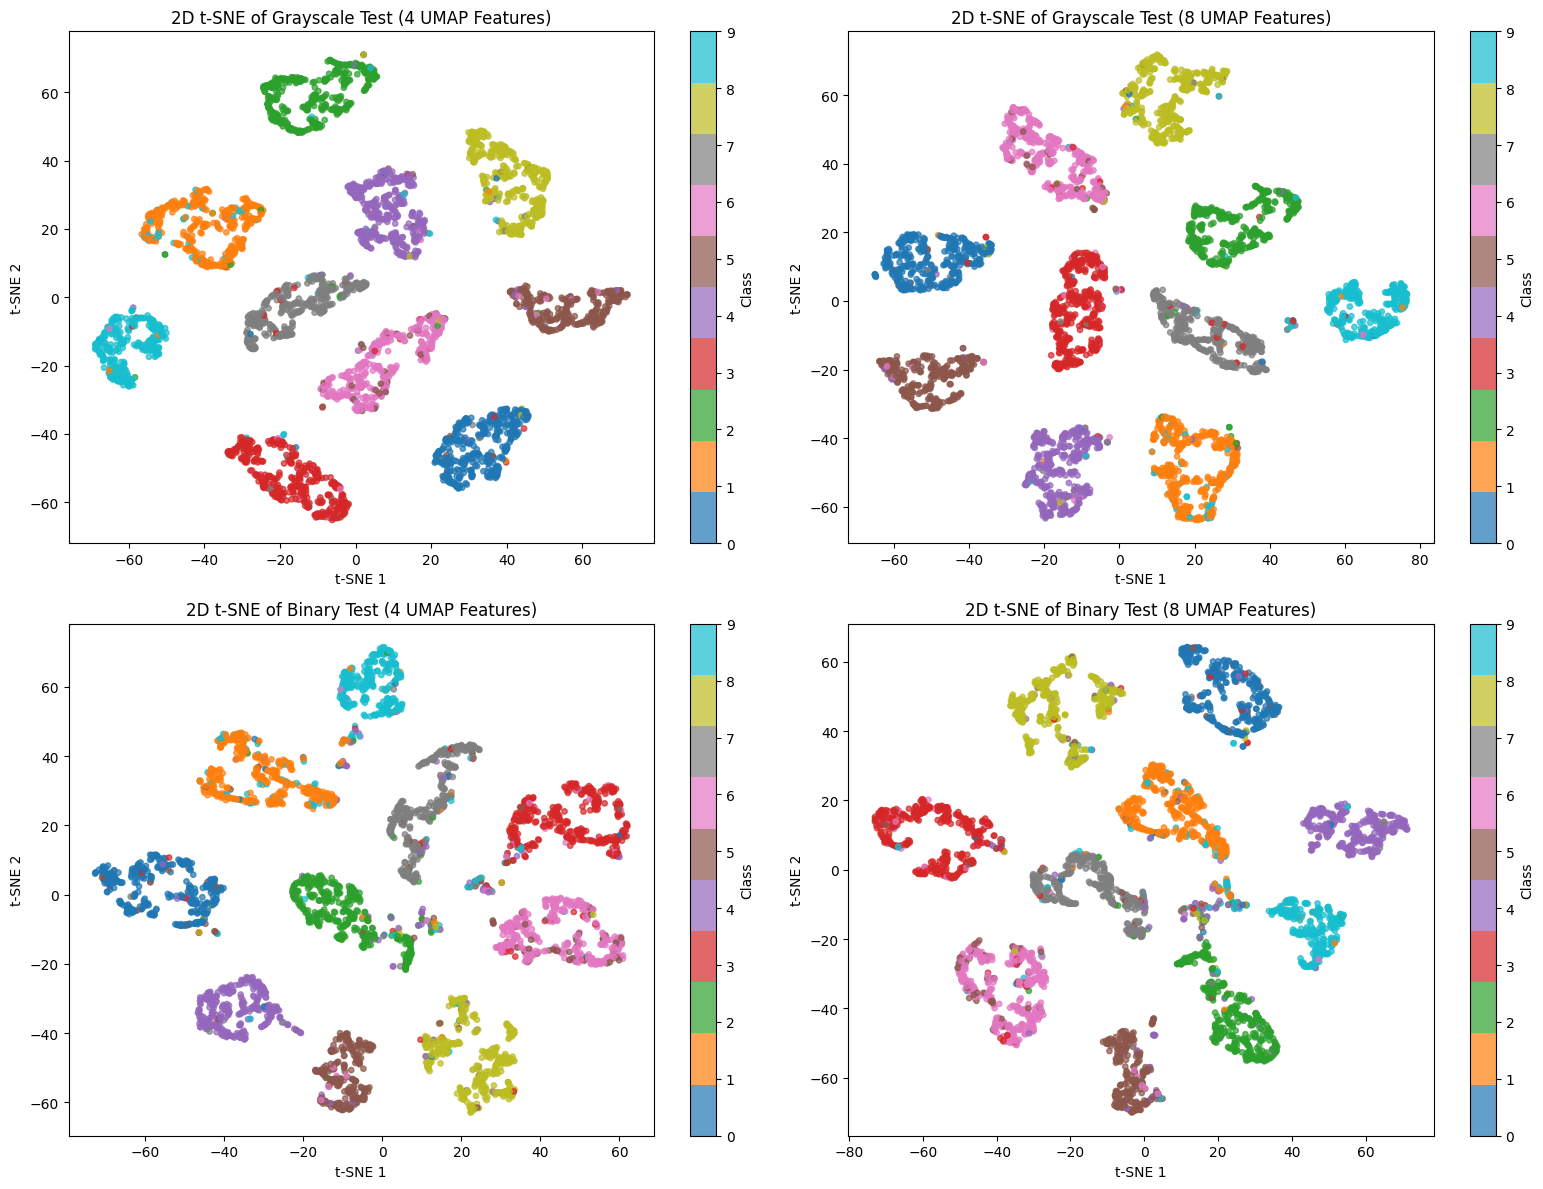

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 3. t-SNE Visualization (Test Set)
# ==========================================

# List of datasets to process (Using the TEST set results)
# Format: (features, labels, title)
datasets = [
    (X_test_gray_umap_4,   y_test_gray,   "Grayscale Test (4 UMAP Features)"),
    (X_test_gray_umap_8,   y_test_gray,   "Grayscale Test (8 UMAP Features)"),
    (X_test_binary_umap_4, y_test_binary, "Binary Test (4 UMAP Features)"),
    (X_test_binary_umap_8, y_test_binary, "Binary Test (8 UMAP Features)")
]

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel() # Flatten 2D array of axes to 1D for easy looping

print("Running t-SNE on Test Sets and plotting...")

for i, (features, labels, title) in enumerate(datasets):
    print(f"  > Processing: {title}...")
    
    # --- t-SNE reduction ---
    # Using specific random_state for reproducibility
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    X_tsne = tsne.fit_transform(features)
    
    # --- Plotting ---
    # Note: Ensure labels are integers or categories for the colormap
    scatter = axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=15, alpha=0.7)
    
    axes[i].set_title(f"2D t-SNE of {title}")
    axes[i].set_xlabel("t-SNE 1")
    axes[i].set_ylabel("t-SNE 2")
    
    # Add a colorbar
    plt.colorbar(scatter, ax=axes[i], label='Class')

plt.tight_layout()
plt.show()

# lda

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
import numpy as np

# Config for split (Ensure this matches your UMAP config for consistency)
TEST_SIZE = 0.2
RANDOM_STATE = 42

# ==========================================
# 3. Processing Grayscale Data (LDA)
# ==========================================
print("Processing Grayscale Data (LDA)...")

# --- Split Train/Test ---
print("   - Splitting Grayscale data into Train/Test...")
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(
    X_gray, y_gray, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Save Labels (Good to overwrite/save to ensure consistency)
np.save("y_train_gray.npy", y_train_gray)
np.save("y_test_gray.npy", y_test_gray)

# --- LDA (4 Features) ---
print("   - Reducing to 4 dimensions (LDA)...")
lda_gray_4 = LinearDiscriminantAnalysis(n_components=4)

# Fit on Train (WITH LABELS), Transform Test
X_train_gray_lda_4 = lda_gray_4.fit_transform(X_train_gray, y_train_gray)
X_test_gray_lda_4 = lda_gray_4.transform(X_test_gray)

np.save("X_train_gray_lda_4.npy", X_train_gray_lda_4)
np.save("X_test_gray_lda_4.npy", X_test_gray_lda_4)

# --- LDA (8 Features) ---
print("   - Reducing to 8 dimensions (LDA)...")
# Note: Max LDA components = min(n_features, n_classes - 1)
# For digits (10 classes), max is 9. So 8 is valid.
lda_gray_8 = LinearDiscriminantAnalysis(n_components=8)

# Fit on Train (WITH LABELS), Transform Test
X_train_gray_lda_8 = lda_gray_8.fit_transform(X_train_gray, y_train_gray)
X_test_gray_lda_8 = lda_gray_8.transform(X_test_gray)

np.save("X_train_gray_lda_8.npy", X_train_gray_lda_8)
np.save("X_test_gray_lda_8.npy", X_test_gray_lda_8)

# Optional check
print(f"   > Saved Gray Train 4-dim shape (LDA): {X_train_gray_lda_4.shape}")
print(f"   > Saved Gray Test 4-dim shape (LDA):  {X_test_gray_lda_4.shape}")


# ==========================================
# 4. Processing Binary Data (LDA)
# ==========================================
print("\nProcessing Binary Data (LDA)...")

# --- Split Train/Test ---
print("   - Splitting Binary data into Train/Test...")
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary, y_binary, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Save Labels
np.save("y_train_binary.npy", y_train_binary)
np.save("y_test_binary.npy", y_test_binary)

# --- LDA (4 Features) ---
print("   - Reducing to 4 dimensions (LDA)...")
lda_binary_4 = LinearDiscriminantAnalysis(n_components=4)

# Fit on Train (WITH LABELS), Transform Test
X_train_binary_lda_4 = lda_binary_4.fit_transform(X_train_binary, y_train_binary)
X_test_binary_lda_4 = lda_binary_4.transform(X_test_binary)

np.save("X_train_binary_lda_4.npy", X_train_binary_lda_4)
np.save("X_test_binary_lda_4.npy", X_test_binary_lda_4)

# --- LDA (8 Features) ---
print("   - Reducing to 8 dimensions (LDA)...")
lda_binary_8 = LinearDiscriminantAnalysis(n_components=8)

# Fit on Train (WITH LABELS), Transform Test
X_train_binary_lda_8 = lda_binary_8.fit_transform(X_train_binary, y_train_binary)
X_test_binary_lda_8 = lda_binary_8.transform(X_test_binary)

np.save("X_train_binary_lda_8.npy", X_train_binary_lda_8)
np.save("X_test_binary_lda_8.npy", X_test_binary_lda_8)

# Optional check
print(f"   > Saved Binary Train 4-dim shape (LDA): {X_train_binary_lda_4.shape}")
print(f"   > Saved Binary Test 4-dim shape (LDA):  {X_test_binary_lda_4.shape}")

Processing Grayscale Data (LDA)...
   - Splitting Grayscale data into Train/Test...
   - Reducing to 4 dimensions (LDA)...
   - Reducing to 8 dimensions (LDA)...
   > Saved Gray Train 4-dim shape (LDA): (15761, 4)
   > Saved Gray Test 4-dim shape (LDA):  (3941, 4)

Processing Binary Data (LDA)...
   - Splitting Binary data into Train/Test...
   - Reducing to 4 dimensions (LDA)...
   - Reducing to 8 dimensions (LDA)...
   > Saved Binary Train 4-dim shape (LDA): (15761, 4)
   > Saved Binary Test 4-dim shape (LDA):  (3941, 4)


Running t-SNE on LDA Test Sets and plotting...
  > Processing: Grayscale Test (4 LDA Features)...
  > Processing: Grayscale Test (8 LDA Features)...
  > Processing: Binary Test (4 LDA Features)...
  > Processing: Binary Test (8 LDA Features)...


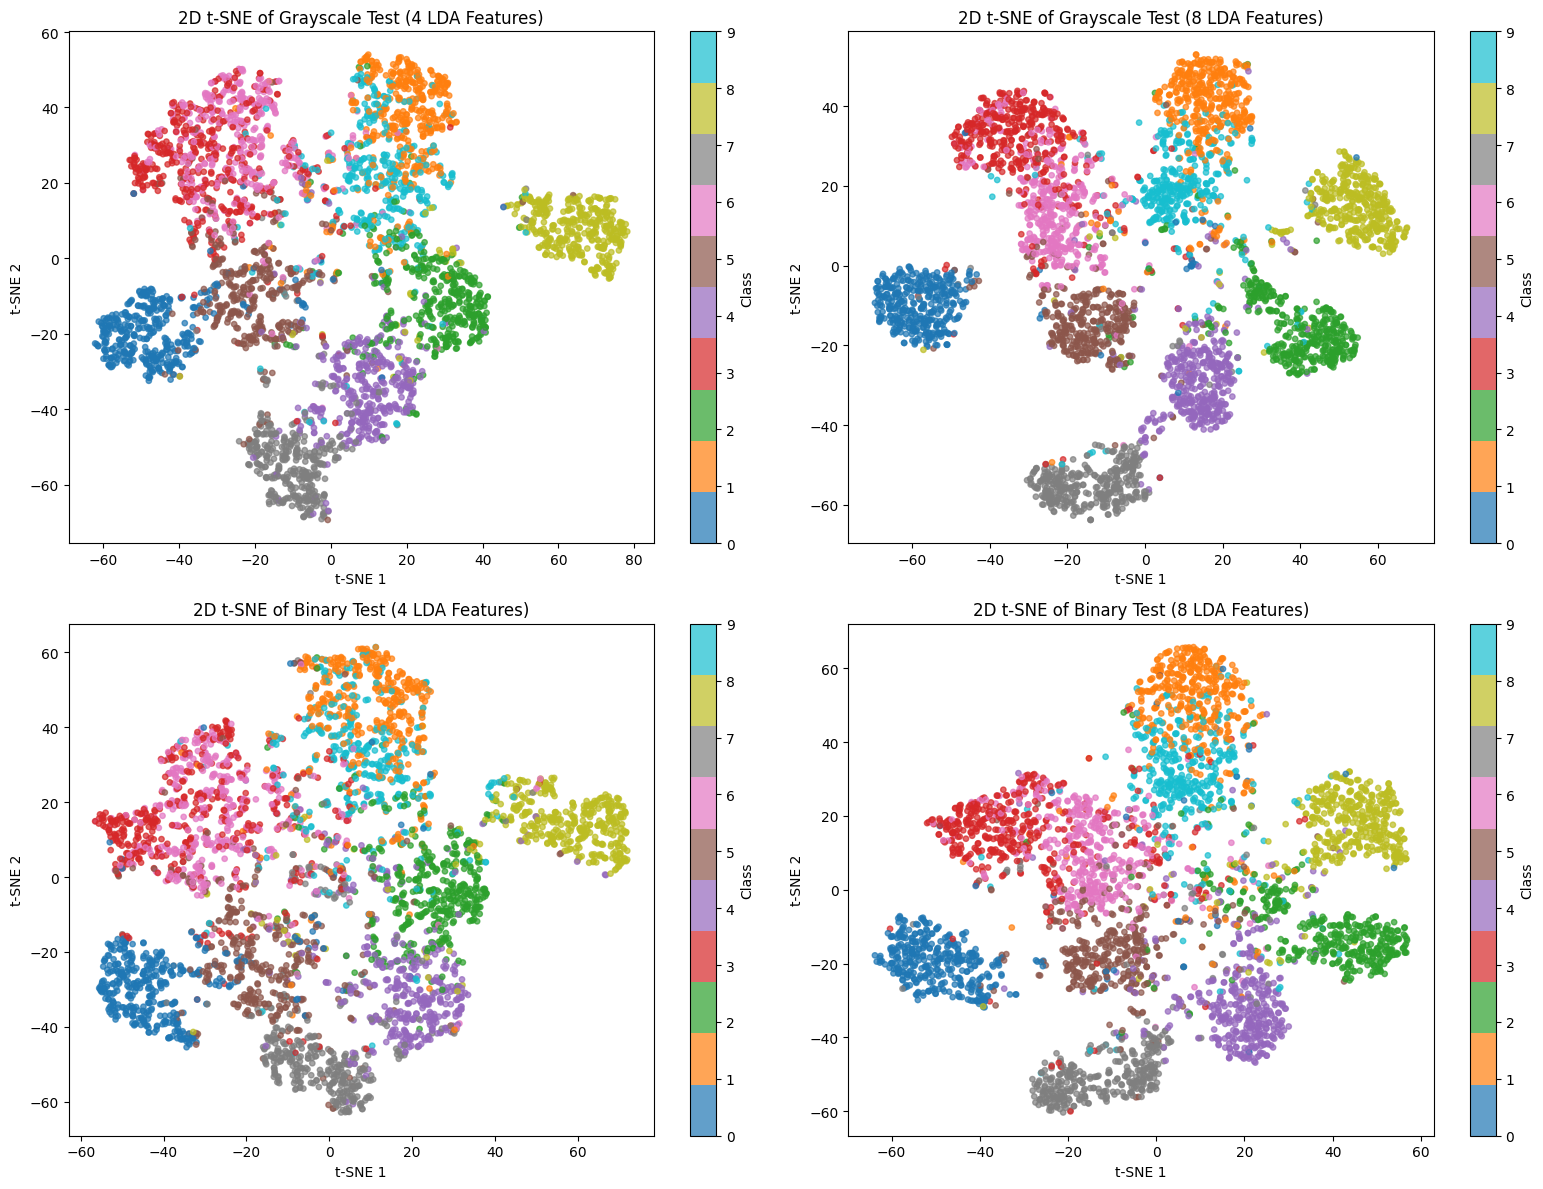

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 5. t-SNE Visualization of LDA Results (Test Set)
# ==========================================

# List of datasets to process (Using the LDA TEST set results)
# Format: (features, labels, title)
datasets_lda = [
    (X_test_gray_lda_4,   y_test_gray,   "Grayscale Test (4 LDA Features)"),
    (X_test_gray_lda_8,   y_test_gray,   "Grayscale Test (8 LDA Features)"),
    (X_test_binary_lda_4, y_test_binary, "Binary Test (4 LDA Features)"),
    (X_test_binary_lda_8, y_test_binary, "Binary Test (8 LDA Features)")
]

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel() # Flatten 2D array of axes to 1D for easy looping

print("Running t-SNE on LDA Test Sets and plotting...")

for i, (features, labels, title) in enumerate(datasets_lda):
    print(f"  > Processing: {title}...")
    
    # --- t-SNE reduction ---
    # Using specific random_state for reproducibility
    # NOTE: t-SNE on LDA data might run faster than on UMAP data because
    # the input dimensions are very low (4 or 8) and LDA has already "cleaned" the data.
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    X_tsne = tsne.fit_transform(features)
    
    # --- Plotting ---
    # Note: Ensure labels are integers or categories for the colormap
    scatter = axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=15, alpha=0.7)
    
    axes[i].set_title(f"2D t-SNE of {title}")
    axes[i].set_xlabel("t-SNE 1")
    axes[i].set_ylabel("t-SNE 2")
    
    # Add a colorbar
    plt.colorbar(scatter, ax=axes[i], label='Class')

plt.tight_layout()
plt.show()